Zachary Rowland

# CPS 491 Main Jupyter Notebook

Contents

* [Python Imports](#Python-Imports) Python imports for the whole document
* [Tensorflow Models](#Tensorflow-Models) Implementations of neural networks used throughout this document
* [Helpful Mathematical Theory](#Helpful-Mathematical-Theory) Math related to the direction of the project
* [Using Tensorflow](#Using-Tensorflow) Quick reference and code examples for using Tensorflow
* [Change-of-Basis Approximation Strategy](#Change-of-Basis-Approximation-Strategy) A general approximation technique using one hidden layer and an arbitrary activation function.
* [Discovering Functions Using SINDy](#Discovering-Functions-Using-SINDy) A data-analysis method for fitting analytical functions to neural networks using linear regression.
* [Approximating an Arbitrary Function using Convolution](#Approximating-an-Arbitrary-Function-using-Convolution) A method for approximating an arbitrary function inspired by convolution.

[Tensorflow Guide](https://www.tensorflow.org/guide/)

This version of the Jupyter notebook is for project release 2. The main content that will guide future exploration can be found under [Discovering Functions Using SINDy](#Discovering-Functions-Using-SINDy), but older work is also included.


# Python Imports

These are just global imports that are used by the whole document. Run the following cell before running anything else.

In [3]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz as gv
import sklearn.linear_model
import tensorflow as tf

# Tensorflow Models

This section defines various learning models that are used throughout this document. The following cell(s) should be run before anything else.

In [ ]:
class NeuralNet(tf.keras.Model):
  """
  A multipurpose neural network.

  Properties:
  * a: the activation function
  * final_a: boolean, apply the activation function to last layer?
  """
  def __init__(self, layers=(1,1,1), final_a=False, **kwargs):
    super().__init__(**kwargs)
    self.thelayers = layers
    self.final_a = final_a
    self.w = []
    self.b = []
    self.a = tf.nn.sigmoid
    self.x = None
    for l in range(len(layers) - 1):
      weights = tf.random.normal(shape=(layers[l], layers[l+1]))
      biases = tf.random.normal(shape=(1, layers[l+1]))
      self.w.append(tf.Variable(weights))
      self.b.append(tf.Variable(biases))
  def print(self):
    print("=== Begin model printout ===")
    l = 0
    while l < len(self.thelayers) - 1:
      print("=== Layer {} ===".format(l))
      tf.print("  w = \n", self.w[l], sep="")
      tf.print("  b = \n", self.b[l], sep="")
      l += 1
    print("=== End model printout ===")
  def printActivations(self):
    """
    Prints the activations of each node from the previous
    feedforward operation.
    """
    print("===  Activations ===")
    l = 0
    while l < len(self.thelayers):
      tf.print(self.x[l])
      l += 1
    print("=== end ===")
  def getW(self, l, i, j):
    """
    Returns the weight from the i-th node in the l-th
    to the j-th node in the (l+1)-th layer
    """
    return float(self.w[l][i,j])
  def getB(self, l, i):
    """
    Returns the bias used to compute the activation of
    the i-th node in the (l+1)-th layer.
    """
    return float(self.b[l][i])
  def __call__(self, x, **kwargs):
    # initialize, type conversion stuff
    wasrowvec = False
    if type(x) == float:
      x = tf.constant([[x]])
    if len(x.shape) == 1:    # convert row vectors to column vectors
      wasrowvec = True
      x = tf.reshape(x, (1, -1))
    
    # propogate values
    self.x = [x]
    l = 0
    while l <= len(self.thelayers) - 3:
      x = self.a(tf.matmul(x, self.w[l]) + self.b[l])
      self.x.append(x)
      l += 1
    x = tf.matmul(x, self.w[l]) + self.b[l]   # final layer
    if self.final_a:
      x = self.a(x)
    self.x.append(x)

    if wasrowvec:
      x = tf.reshape(x, (-1,))
    return x


---

# Helpful Mathematical Theory

## Linear Systems Background

Some vocabulary:

* **Def** A _signal_ (denoted with $x$ or $y$) just refers to a real-valued function (usually over time). Alternatively, it can be thought of as a list of (output) values.
* **Def** _Shifted signal_: $x \Rsh s$ is the signal such that $(x \Rsh s)(t) = x(t - s)$. Usually, $x(t - s)$ denotes the shifted signal itself, but using the denotation $\Rsh$ clarifies that shifting is an operation on a signal. 
* **Def** A _system_ or _transform_ (denoted $T$) is a "function on functions", a transformation from one signal to another.
* **Def** A _linear system_ is a system that satisfies homogeneity and additivity from linear algebra.
* **Def** A _shift-invariant system_ $T$ satisfies the property $T[x \Rsh s] = T[x] \Rsh s$ for any signal and shift amount.
* **Def** The _unit impulse_ signal (denoted $\delta(t)$) is a spike at time zero and is defined such that:
$$ \int_{-\infty}^{t} \delta(\tau)\ d\tau = \begin{cases} 0 \qquad t < 0 \\ 1 \qquad t > 0 \end{cases}$$

Any signal can be represented as a linear combination of shifted and scaled impulse signals:
$$ x(t) = \int_{-\infty}^{\infty} x(\tau)\ \delta(t - \tau)\ d\tau $$

Suppose $T$ is a linear shift-invariant transform. Then, by properties of linearity and shift-invariance:
$$ T[x(t)] = \int_{-\infty}^{\infty} x(\tau)\ (T[\delta])(t - \tau) \ d\tau $$
This means that $T$ is completely characterized by how it maps the unit impulse signal. $T[\delta]$ is called the _impulse response signal_.

**Def** A _convolution_ is a combination of two signals. We say $x * y$ is the result of convolving $x$ with $y$.
  $$ (x * y)(t) = \int_{-\infty}^{\infty} x(\tau)\ y(t - \tau)\ d\tau $$
  $$ x * y = \int_{-\infty}^{\infty} x(\tau)\ (y \Rsh \tau)\ d\tau $$
  Think of convolution as constructing a new signal that is a linear combination of a set of base signals. But each base signal is just a shifted version of a single signal $y$. The factors that scale the base signals are the outputs of $x$.

Special Convolutions:
 * $x * \delta = x$
 * $x * 1 = \int_{-\infty}^{\infty} x(\tau)\ d\tau$
 * $x * \text{step} = \int_{-\infty}^{t}x(\tau)\ d\tau \qquad$ ("step" is the integral of $\delta$)



Differentiation on real functions is a shift-invariant linear operation, so it can be expressed as a convolution ($d$ is the "derivative" of $\delta$):
$$ \frac{dx}{dt} = x * d = \int_{-\infty}^{\infty} x(\tau)\ (d \Rsh \tau)\ d\tau $$

A Taylor series is similar to a convolution, but uses a discrete sum instead of the continuous integral.

$$ f(x) = \sum_{n=0}^{\infty} \frac{f^{(n)}(a)}{n!} (x - a)^n \qquad \forall x, a \in \mathbb{R} $$

$$ f(x) = \sum_{n=0}^\infty \frac{f^{(n)}(0)}{n!} x^n $$

## Neural Net vs. Fuzzy Inference System

The feedforward calculation of a neural network is a (linear) affine transformation composed with a nonlinear function $\sigma$.

$$ x^{(l+1)} = \sigma(W^{(l)} x^{(l)} + b^{(l)}) \qquad \text{whole layer}$$

$$ x^{(l+1)}_i = \sigma\left( \sum_j W_{i,j}^{(l)} x_j^{(l)} + b_i^{(l)} \right) \qquad \text{single node} $$

_Index confusion_:
* _Superscripts in parentheses_ always refer to the layer.
* _Subscripts_ index the elements within a particular layer. Vectors only have one subscript. Matrices have two comma-separated subscripts for the _row_ and _col_ respectively. Letting the _col_ vary looks like moving left-right across the matrix.
* Matrix vector multiplication example: $\sum_j W_{i,j}x_j = (Wx)_i$

### Piecewise-linear neural network

If the activation function $\sigma$ is piecewise-linear, such as a rectified linear or absolute value, then the entire feed-forward network will be piecewise-linear because composing two piecewise-linear functions yields another piecewise-linear function.

**Theorem** The composition of two piecewise-affine functions is itself piecewise-affine.

**Proof** Let $f$ and $g$ be piecewise-affine. Since $f$ is piecewise, the domain of $f$ can be divided into regions $\{r_1, r_2, ...\}$ such that $f$ is purely affine on any one region $r_i$. The same can be said for $g$ on regions $\{s_1, s_2, ...\}$. Now the composition of two purely affine functions is itself affine. This means that $(g \circ f)$ is affine on any region $r_i \cap \{x | f(x) \in s_j\}$ since this region is a subset of $r_i$, and its mapping via $f$ is a subset of $s_j$. So $(g \circ f)$ is piecewise-affine.

### Fuzzy Inference System

The function defined by a fuzzy inference system $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$ is piecewise-polynomial of degree $n$. This is because for each region in the domain, $f$ is defined as a linear combination of $2^n$ membership functions. As an example, for a one-input one-output system, on the domain $[0,1]$, these membership functions are $(1 - x)$ and $x$.

$$ f(x) = c_0(1 - x) + c_1x $$

If the input becomes 2-dimensional, then $f$ on the unit square becomes:

$$ f(x,y) = c_{00}(1-x)(1-y) + c_{01}(1-x)y + c_{10}x(1-y) + c_{11}xy $$

Each additional variable requires an additional multiplication in the definition of the membership functions.

## Universal Approximation Theorem

The universal approximation theorem says that neural networks with either arbitrary width or depth can approximate any continuous function to arbitrary accuracy.

* **Arbitrary Width** Given a non-polynomial activation function $\sigma: \mathbb{R} \rightarrow \mathbb{R}$ and input,output dimensions $d,D \in \mathbb{Z}^+$
 * for every continuous function $f: \mathbb{R}^d \rightarrow \mathbb{R}^D$,
 * for every compact subset $K$ of $\mathbb{R}^d$,
 * for every $\epsilon > 0$,
 * there exists linear affine maps $W_1, W_2$ such that
 * $\sup| f(x) - (W_2 \circ \sigma \circ W_1)(x) | < \epsilon$
* **Arbitrary Depth**
 * for every function $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$,
 * for every $\epsilon > 0$,
 * there exists a fully-connected ReLU network $F$ with width $d_m = \max\{n+1,m\}$ such that,
 * $\int_{\mathbb{R}^n} | f(x) - F(x) |^p dx < \epsilon$

## Fourier Series

Fourier's Theorem states that any periodic function $f$ with period $L$ can be written as a sum of sines and cosines:

$$ f(x) = a_0 + \sum_{n=1}^{\infty} \left[ a_n\cos\left(\frac{2\pi nx}{L}\right) + b_n\sin\left(\frac{2\pi nx}{L}\right) \right] \qquad \text{(Fourier's Theorem)} $$

where the coefficients can be calculated as follows:

$$ a_n = \frac{2}{L}\int_0^{L} f(x)\cos\left( \frac{2\pi nx}{L} \right)\ dx $$
$$ b_n = \frac{2}{L}\int_0^{L} f(x)\sin\left( \frac{2\pi nx}{L} \right)\ dx $$

There is an equivalent exponential form that also generalizes to complex functions:

$$ f(x) = \sum_{n=-\infty}^{\infty} C_n e^{i\, 2\pi nx/L} \qquad \text{(Fourier's Theorem)} $$

$$ C_n = \frac{1}{L}\int_0^L f(x) e^{i\, 2\pi nx/L}\ dx $$

## Fourier Approximations

Fourier approximations work because the set of functions $\{\frac{1}{\pi}\sin nx | n \ge 1\} \cup \{\frac{1}{\pi} \cos nx | n \ge 1\} \cup \{\frac{1}{2\pi}\}$ forms an orthonormal basis of the set of real-valued functions with period $2\pi$. This is because:

* All functions in this set have unit length (e.g. $\int_0^{2\pi} \sin^2 (nx)\ dx = 1$)
* All functions in this set are pairwise orthogonal (e.g. $\int_0^{2\pi} \sin(nx)\cos(mx)\ dx = 0$)
* There are "enough" of them to span the entire vector space

Finding the Fourier approximation of a function $f$ just requires calculating the coorinates of $f$ in this new basis. Recall the projection formula:

$$ \text{proj}_{\vec{w}} \vec{v} = \frac{\vec{v} \cdot \vec{w}}{||\vec{w}||^2} \vec{w} $$

So we just need to project our function $f$ onto each basis vector. For example,

$$ \text{proj}_{\sin(x)/\pi} f = \frac{1}{\pi^2} \left( \int_0^{2\pi} f(x) \sin(x)\ dx \right) \sin(x) $$

Similar approximations can be done with any set of orthogonal functions such as [orthogonal polynomials](https://en.wikipedia.org/wiki/Orthogonal_polynomials).

The discrete Fourier Transform transforms a sequence of complex numbers $ x_0, x_2, \dots, x_{N-1} $ into another sequence:

$$ X = F\pmb{x} $$

$$ \begin{bmatrix} X_0 \\ X_1 \\ \vdots \end{bmatrix} = \begin{bmatrix} \omega^{0 \cdot 0} & \omega^{0 \cdot 1} & \\ \omega^{1 \cdot 0} & \omega^{1 \cdot 1} & \cdots \\ & \vdots & \end{bmatrix} \begin{bmatrix} x_0 \\ x_1 \\ \vdots \end{bmatrix} $$

$$ \omega = e^{-\frac{2 \pi i}{N}} $$



## Spline Theory

Notes from "A Spline Theory of Deep Networks" by Balestriero and Baraniuk.

* **Def** A function $f: \mathbb{R^n} \rightarrow \mathbb{R}$ is _convex_ if the line segment connecting any two points on the graph lies entirely above the graph (think positive concavity or positive second derivative).
* **Def** An _affine spline_ is a continuous piecewise-affine function ($\mathbb{R^n} \rightarrow \mathbb{R}$).
* **Def** A _max-affine spline_ is defined as the maximum of a set of affine functions over the entire domain. Max-affine splines are necessarily globally convex and continuous no matter the choices of affine functions.
* **Def** An _adaptive-partitioning spline_ (such as a max-affine spline) is a spline were the domain partitioning is not a direct parameter, but instead determined by other parameters, and where the domain partitioning automatically changes as the direct parameters change.
* **Def** An _affine spline operator_ is obtained by simply concatenating affine splines to produce a function with multivariate output.
* **Def** A _max-affine spline operator_ (MASO) is an affine spline operator produced by concatenating max-affine splines.

Main result: most deep networks can be written as a composition of MASOs, one for each layer, even though a MASO can only approximate a convex function.

## Linear Regression with Vectors

Suppose we have $n$ datapoints $(x_i, y_i)$ where $x_i, y_i \in \mathbb{R}$. A linear regression problem attempts to find a function $f(x) = mx + b$ such that some sort of error function, like square differences, are minimized. This problem can reframed as finding values of $m,b$ such that the approximation below is "closest"

$$ \pmb{y} \approx X \pmb{ w } $$
$$ \begin{bmatrix} y_0 \\ y_1 \\ \vdots \end{bmatrix} \approx \begin{bmatrix} x_0 & 1 \\ x_1 & 1 \\ \vdots & \vdots \end{bmatrix} \begin{bmatrix} m \\ b \end{bmatrix} $$

Here is another interpretation of the above equation: Given each $x_i$, the vector $\pmb{y}$ is a representation of a function (think of "coordinates"). It represents a function by simply listing outputs associated with the given inputs. This vector sits in some vector space $V$. The columns of the $X$ matrix are also vectors in $V$ (representations of $x \mapsto x$ and $x \mapsto 1$).

But $\pmb{w}$ is a different representation of a function in a different, lower-dimensional vector space $W$. The matrix $X$ maps vectors from $W$ into $V$. The problem now becomes: "find the vector $\pmb{w}$ such that the distance from $\pmb{y}$ to $X\pmb{w}$ is minimum":

$$ \pmb{w} = \min_{w} || Xw - \pmb{y} ||^2 $$

There are two ways of finding $\pmb{w}$. The more traditional way is to use calculus. The partial derivatives are taken with respect to $m$ and $b$. Note that this is just another way to say that the sum of the square differences must be minimum.

$$ \nabla || X\pmb{w} - \pmb{y} ||^2 = \pmb{0} $$

Another way is to project the vector $\pmb{y}$ onto the space $X(W)$. The vectors $\pmb{w_i}$ can be any orthogonal basis of $W$.

$$ X(\pmb{w}) = \text{proj}_{X(W)}(\pmb{y}) = \sum_i \frac{\pmb{y} \cdot X(\pmb{w_i})}{|| X(\pmb{w_i}) ||^2} X(\pmb{w_i}) $$


Approximation: 0.40 + 0.60x + -1.41x^2


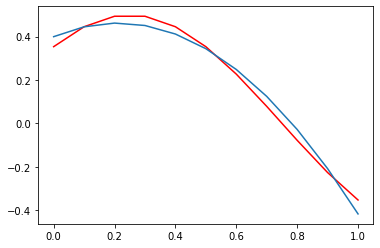

In [ ]:
# Example: quadratic regression using the projection method

# Generate data   yvec = 0.5sin(pi xvec + pi/4)
n = 11
xvec = np.linspace(0.0, 1.0, num=n)
yvec = 0.5 * np.sin(np.pi * xvec + np.pi * 0.25)
xsquarevec = xvec ** 2.0
onesvec = np.ones((n,))

# Construct the X matrix
X = np.column_stack((onesvec, xvec, xsquarevec))

# Calculate Xw by projecting onto the orthogonal basis "Xorth"
Xorth, _ = np.linalg.qr(X)
Xw = np.zeros((n, 1))
for c in range(3):
  col = Xorth[:,c:c+1]
  Xw = Xw + (np.matmul(yvec, col) / np.sum(col ** 2.0)) * col

# To get the original w vector, take any three coordinates from
# Xw and the corresponding rows from T. Then w = inv(X) Xw
Xsquare = np.resize(X, (3, 3))
w = np.matmul(np.linalg.inv(Xsquare), np.resize(Xw, (3,1)))
print("Approximation: {:.2f} + {:.2f}x + {:.2f}x^2".format(w[0,0], w[1,0], w[2,0]))

plt.plot(xvec, yvec, color="red")
plt.plot(xvec, [w[0,0] + w[1,0]*x + w[2,0]*x*x for x in list(xvec)])
plt.show()


## Dimensionality Reduction

* **Def** _Dimensionality reduction_ refers to some method of squeezing high dimensional data into a lower dimensional space in some meaningful way. These transformations can be linear or non-linear.
* **Def** _Feature selection_ is probably the simplest linear dimensionality reduction strategy. You simply eliminate one or more variables that are deemed unimportant.
* **Def** _Feature projection_ a generic linear dimensionality reduction strategy. Instead of naively eliminating one or more variables, you linearly-project the data into a smaller dimensional space. Think of rewriting the data in a different basis, then performing a feature selection.

* **Def** The _covariance_ of two random variables $X,Y$ is a measure of their correlation. A covariance near zero means they are independent. While univariable variance is $E(X - E(X))^2$, covariance is $E(X - E(X))(Y - E(Y))$.
* **Def** The _covariance matrix_ of $d$-dimensional data is a $d \times d$ matrix containing the covariances of each pair of dimensions.

The eigenvectors of the covariance matrix represent sort of the "principal components" of the distribution. If you were to rewrite the data using the eigenvector coordinates, the eigenvectors corresponding to the largest eigenvalues represent the directions in which the data is the most "spread out" or the most varied.

* **Def** _Principal Component Analysis_ is the primary version of feature projection where we keep the features in which the data is the most varied and eliminate features where the data does not vary as much. We can do this by rewriting the data in terms of a basis of eigenvectors of the covariance matrix and discard the "shortest eigenvectors" (smallest eigenvalues).

* **Dynamic Mode Decomposition** Another feature projection technique.


---

# Using Tensorflow

An brief overview of tensor math and learning models in the Tensorflow library descibed with lots of code examples.

In [ ]:
# generating simple test data

f = open("sin_data.csv", "w")
f.write("x,sin(x)\n")
for i in range(200):
  x = random.random()*2*math.pi
  v = math.sin(x)
  f.write(str(x)+","+str(v)+"\n")
f.close()

In [ ]:
# example loading CSV file into a pandas dataframe
sin_dataframe = pd.read_csv("sin_data.csv", sep=",")  # type is pd.DataFrame
sin_dataframe.head(3)   # returns a new dataframe with only first 3 rows

,x,sin(x)
0,2.438507,0.646574
1,4.413438,-0.955646
2,1.221277,0.939538


## Tensor Math

The primary objects that Tensorflow provides are tensors -- a generalization of scalars, vectors, and matrices to numerical arrays of arbitrary dimension. Tensors have the following properties:

* **dimension**: the number of layers of nested lists needed to represent the tensor (e.g. a vector is a 1-D tensor, a matrix is a 2-D tensor).
* **shape**: a list of numbers describing the "length" of the tensor in each direction (e.g. matrices all have shape (nrows, ncols)).

In [ ]:
# Tensors
t0 = tf.constant(4)   # a rank-0 tensor (i.e. a scalar)
t1 = tf.constant([1,2,3])   # a rank-1 tensor (i.e. a vector)
t2 = tf.constant([[1,2,3], [4,5,6], [7,8,9]])   # a rank-2 tensor (i.e. a matrix)

# constructing simple tensors
t = tf.zeros([3,2])   # a 3x2 tensor filled with zeros
t = tf.random.uniform([3,2], minval=0, maxval=1)
t = tf.random.normal([3,2], mean=5, stddev=2)
t = tf.eye(4)   # 4x4 identity matrix

t = tf.constant([[1,2], [3,4]], dtype=tf.float32)  # manually specify element type

a = np.array(t)   # convert Tensor to numpy array
t = tf.constant(a)  # convert numpy array to Tensor

# Tensor operations
ta = tf.constant([[1,2],[3,4]], dtype=tf.float32)
tb = tf.constant([[5,6],[7,8]], dtype=tf.float32)
t = ta + tb   # element-wise addition
t = ta * tb   # element-wise multiplication
t = ta @ tb   # "matrix" multiplication
t = tf.reduce_max(ta)   # largest value
t = tf.argmax(ta)       # index of largest value
b = ta == tb            # comparison operators are element-wise

# Tensor shape, rank, dimension, size
t = tf.constant([[1,2,3],[4,5,6]])
shape = t.shape     # [2, 3]
anelem = t[0,0]     # indexing (returns a Tensor)
anelem = t[0][0]    # also indexing
t = tf.reshape(t, (3, 2))   # does not shuffle elements in memory, so cheap


## Automatic Differentiation

A _gradient_ is an operation on a scalar-valued function with a tensor input $f: T \rightarrow \mathbb{R}$. The result of calculating the gradient of a function $\nabla f$ is a tensor of same shape as the input. A _Jacobian_ is the generalization of the gradient to tensor-valued functions. If $f: T_{d_1 \times \dots \times d_n} \rightarrow T_{\delta_1 \times \dots \times \delta_m}$, then $\mathbf{J} f: T_{\delta_1 \times \dots \times \delta_m \times d_1 \times \dots \times d_n}$.

In [ ]:
# Automatic Differentiation & Variables

x = tf.Variable([[1],[2],[3]], name="x", dtype=tf.float32)

# a "tape" is needed to store automatic differentiation values
# call GradientTape with persistent=True if you want to calculate multiple
# gradients or jacobians
with tf.GradientTape() as tape:
  y = tf.constant([[1,1,1], [5,1,0]], dtype=tf.float32) @ x

print(y)
j = tape.jacobian(y, x)   # j[output indeces, input indices]

# j[output indeces][input indices] is the derivative
# of output[output indeces] with respect to input[input indeces]

# For example, j[1,0][2,0] is derivative of second component of y
# with respect to the third component of x

tf.Tensor(
[[6.]
 [7.]], shape=(2, 1), dtype=float32)


## A Linear Neural Network

Note that normally, a linear feed-forward function for one layer is written as $W\vec{x} + \vec{b}$. However in tensorflow, vectors are one-dimentional tensors instead of $n \times 1$ matrices, which means it is slightly easier to define this function as $\vec{x}W^t + \vec{b}$.

In [ ]:
# A 1-input 1-output linear neural network.
class LinearModel(tf.keras.Model):
  def __init__(self, indim, outdim, **kwargs):
    super().__init__(**kwargs)
    self.indim = indim
    self.outdim = outdim
    self.w = tf.Variable(tf.random.normal(shape=(indim, outdim)))
    self.b = tf.Variable(tf.random.normal(shape=(1, outdim)))
  def __call__(self, x, **kwargs):
    return tf.matmul(x, self.w) + self.b

# model and test data
mymodel = LinearModel(1, 1)
mymodel.compile(run_eagerly=False,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.2),
                loss=tf.keras.losses.mean_squared_error)
x = tf.random.uniform(shape=(1000,1,1), minval=-1, maxval=1)
y = x * 0.5 + tf.random.normal(shape=(1000,1,1), mean=0.3, stddev=0.05)
y_obs = mymodel(x)

In [ ]:
# training

mymodel.fit(x, y, epochs=10, batch_size=1000, verbose=1)
y_obs = mymodel(x)


Epoch 1/10
1/1 [==============================] - 0s 297ms/step - loss: 0.3333
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.1694
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0984
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0638
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0446
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0326
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0188
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0115


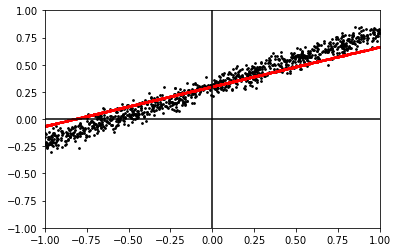

In [ ]:
# show results
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.axhline(color="black")
plt.axvline(color="black")
plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

---

# Change-of-Basis Approximation Strategy

This section describes a general strategy for approximating any function $f: \mathbb{R} \rightarrow \mathbb{R}$ with a neural network using an arbitrary activation function $a$ (with certain restrictions) to any desired accuracy using a single hidden activation layer. The basic idea is to find a representation of $f$ as a linear combination of various functions of the form $a(hx + k)$. For a more concrete example, see [Using Maclaurin Approximation](#scrollTo=iZycguIdbhuG).

Start with:
* $f: \mathbb{R} \rightarrow \mathbb{R}$ the function to be approximated
* $a: \mathbb{R} \rightarrow \mathbb{R}$ an activation function
* A function basis $\mathcal{F}$, for example:
  * polynomials $\{1, x, x^2, ...\}$
  * sinusoids $\{1, \sin(x), \cos(x), \sin(2x), \dots\}$
* A methodology for producing an approximation $f_{app}$ of $f$ using finite subsets of the basis $\mathcal{F}$
  * Maclaurin series (requiring $f_{app}^{(n)}(0) = f^{(n)}(0)$ for some values $n \ge 0$)
  * Point Sampling (requiring $f_{app}(n) = f(n)$ for some values $n$)
  * Matching Integrals (requring $\int_R f^{(n)}_{app}(x)\ dx = \int_R f^{(n)}(x)\ dx$ for some values $n \ge 0$)
  * Remez Algorithm
  * Fourier series

General process:
1. Find an approximation $f_{app}$ of $f$ that is a linear combination of $d$ vectors in $\mathcal{F}$.
2. Construct a set of independent functions $\mathcal{A} = \{a(h_0 x + k_0), a(h_1 x + k_1), \dots, a(h_d x + k_d) \}$
3. Construct a basis $\mathcal{B}$ of approximations of the functions in $\mathcal{A}$ where $\mathcal{B}_i \approx \mathcal{A}_i$
4. Construct a change of basis matrix $B = \begin{bmatrix} \mathcal{B}_0 & \mathcal{B}_1 & \cdots & \mathcal{B}_d \end{bmatrix}$ that converts from $\mathcal{B}$-coordinates to $\mathcal{F}$-coordinates.
5. Find the coordinates of $f_{app}$ in $\mathcal{B}$ by inverting the change of basis matrix: $\text{coords}_{\mathcal{B}}(f_{app}) = B^{-1}\ \text{coords}_{\mathcal{F}}(f_{app})$

The numbers in $\text{coords}_{\mathcal{B}}(f_{app})$ are the weights coming out of the neurons in the hidden layer of the network. The weights and biases fed _into_ the hidden layer neurons are the $h,k$ values from step 2.

There are two approximations happening: the approximation of $f$ and the approximation of $a$. Both approximations are represented in the same finite-dimensional subspace of $\mathcal{F}$, meaning the transformation from one to the other is a finite linear operator.



## Using Maclaurin Approximation

Here is an example of applying the above approximation strategy using Maclaurin series approximation and the standard basis for $d$-degree polynomials for $\mathcal{F}$.

To start, we will use $\mathcal{A} = \{a(0), a(hx), a(2hx), \dots, a(dhx)\}$

The approximations $\mathcal{B}$ will be found using the first $d$ terms of the Maclaurin expansion.

$$ \mathcal{A}_j = a(khx) \approx \sum_{n=0}^{d} \frac{j^n h^n a^{(n)}(0)}{n!} x^n = \mathcal{B}_j $$

Now construct the change of basis matrix $B$. The columns of $B$ are the vectors in $\mathcal{B}$ written with respect to the standard polynomial basis $\{1, x, x^2, \dots, x^d\}$. Note that $a^{(i)}(0) \ne 0$ for $0 \le i \le d$ otherwise the matrix will not be invertible.

$$ B = \begin{bmatrix} \mathcal{B}_0 & \mathcal{B}_1 & \cdots & \mathcal{B}_d \end{bmatrix} $$

$$ B_{i,j} = \frac{j^i h^i a^{(i)}(0)}{i!} $$

Multiplying by $B$ on the left will convert coordinates with respect to $\mathcal{B}$ into standard basis coordinates. Both coorinate vectors are column vectors. $p$ is the $d$-degree polynomial approximation of $f$.

$$ B\ \text{coords}_{\mathcal{B}}(p) = \text{coords}(p) $$

To get the new coordinates with respect to $\mathcal{B}$, simply multiply the standard coordinates by the inverse of $B$.

$$ \text{coords}_{\mathcal{B}}(p) = B^{-1} \text{coords}(p) $$

Our neural network function that approximates $p$ is

$$ p(x) = \lim_{h \rightarrow 0} \left( \text{coords}_{\mathcal{B}}(p) \cdot a(\begin{bmatrix} 0 & hx & 2hx & \cdots & dhx \end{bmatrix}^t) \right) $$

In [ ]:
# returns an approximation for poly
# poly is a list [b0, b1, b2, ...] representing b0 + b1x + b2x^2 + b3x^3 + ...
# a_derivs is the list [a(0), a'(0), a''(0), ...]
# h should be close to zero (0.1 usually works well)
# returns the coefficients [c0, c1, c2, ...] such that
# c0 a(0) + c1 a(hx) + c2 a(2hx) + ... approximates poly
def getApprox(poly, a_derivs, h):
  degree = len(poly) - 1
  # construct B matrix
  # Note, the B matrix in the math above is actually matmul(C, B) where C
  # is a diagonal matrix of "row coefficients"
  B = []
  for row in range(degree + 1):
    B.append([])
    for col in range(degree + 1):
      B[row].append(math.pow(col, row))
  B = np.array(B)

  C_inv = []
  for row in range(degree + 1):
    C_inv.append([])
    coefficient = math.factorial(row) / (math.pow(h, row) * a_derivs[row])
    for col in range(degree + 1):
      C_inv[row].append(coefficient if row == col else 0.0)
  C_inv = np.array(C_inv)

  # construct coords vector
  coords = np.array(poly).reshape((degree+1, 1))

  return np.matmul(np.matmul(np.linalg.inv(B), C_inv), coords)

# derivatives of 1/(1+exp(-(x-1)))
#a_derivs = [0.26894142137, 0.196611933241, 0.0908577476729, -0.0353255805162, -0.123506861366, -0.0510419761245]

# derivatives of 1/(1+exp(-(5x - 1)))
a_derivs = [0.26894142137, 0.983059666207, 2.27144369182, -4.41569756453, -77.191788354, -159.506175389]

# approximate x - (1/6)x^3, a Maclaurin approx for sin(x).
#getApprox([0.0, 1.0, 0.0, -1.0/6.0], [0.26894142137, 0.196611933241, 0.0908577476729, -0.0353255805162], 0.5)

# approximates 0.5 sin(pi x) + 0.5
# via its degree-5 maclaurin expansion
getApprox([0.5, 1.57079632679, 0.0, -2.58385639002, 0.0, 1.27508201994],
          a_derivs, 0.5)

array([[ -25.07715296],
       [  97.79126971],
       [-151.51657341],
       [ 122.7842585 ],
       [ -50.69813563],
       [   8.5754747 ]])

In [ ]:
# len(inputs) = len(outputs) = d + 1
# returns the unique d-degree polynomial p that
# satisfies p(inputs[i]) = outputs[i] for each i.
def getPolyApprox(inputs, outputs):
  degree = len(inputs) - 1
  M = []
  for row in range(degree + 1):
    M.append([])
    for col in range(degree + 1):
      M[row].append(math.pow(inputs[row], col))
  M = np.array(M)

  outputs = np.array(outputs).reshape((degree+1, 1))
  return np.matmul(np.linalg.inv(M), outputs)

def pointSampledApprox(a, p):
  degree = len(p) - 1
  basis = []
  for i in range(degree+1):
    c = i / (degree+1)
    a_shifted = lambda x: a(5.0 * (x - c))
    inputs = [x / degree for x in range(degree+1)]
    outputs = [a_shifted(x) for x in inputs]
    basis.append(getPolyApprox(inputs, outputs))

  B = np.column_stack(basis)
  print(np.matmul(np.linalg.inv(B), np.array(p).reshape((degree+1, 1))))


In [ ]:
p = getPolyApprox([0.0, 0.25, 0.5, 0.75, 1.0], [0.5, 1.0, 0.5, 0.0, 0.5])
pointSampledApprox(lambda x: 1.0 / (1.0 + math.exp(-x)), p)

[[-2.47988103]
 [10.84523535]
 [-9.37800578]
 [-3.47771911]
 [ 5.89490843]]


## Catalog of Approximations

Can we make a catalog of neural networks that approximate common mathematical functions?

* $f(x) = x$
  * Maclaurin approx.
    * Formula: $\frac{1}{ha'(0)}(a(hx) - a(0))$
    * Conditions: $h \approx 0$, $a'(0) \ne 0$
* $f(x) = x^2$
  * Maclaurin approx.
    * $\frac{1}{h^2 a''(0)} (a(-hx) -2a(0) + a(hx))$
    * Conditions: $h \approx 0$, $a''(0) \ne 0$
* $f(x) = \sin(x)$
  * Cubic Maclaurin approx. ($x - \frac{1}{6}x^3$)
    * Formula: $-56.393a(0) + 143.749a(0.5x) - 128.491a(x) + 41.135a(1.5x)$

---

# Discovering Functions Using SINDy

Paper:
Brunton, Steven L., et. al. "Sparse Identification of Nonlinear Dynamics with Control (SINDYc)." 2016. https://arxiv.org/abs/1605.06682.

SINDy is a method for fitting functions to time data using linear regression. SINDy finds a best fit function of the form $f(x) = w_0 f_0(x) + w_1 f_1(x) + \cdots + w_n f_n(x) + b$ for time data $(x_t, y_t)$. More precisely, it finds the coefficients $w_i$ and $b$ that optimize the approximation:

$$ \begin{bmatrix} y_0 \\ y_1 \\ \vdots \end{bmatrix} \approx \begin{bmatrix} f_0(x_0) & f_1(x_0) \\ f_0(x_1) & f_1(x_1) & \cdots \\ \vdots & \vdots \end{bmatrix} \begin{bmatrix} w_0 \\ w_1 \\ \vdots \end{bmatrix} + b \begin{bmatrix} 1 \\ 1 \\ \vdots \end{bmatrix}$$

The approximation above is specifically for functions $f: \mathbb{R} \rightarrow \mathbb{R}$, but it generalizes to data of arbitrary dimensions.

We could use SINDy to fit functions based on input/output data from a trained neural network. The main two questions are:
1. What is the best way to gather data from a trained neural network?
2. What sets of functions $f_i$ can we use to give us useful information? The $f_i$ functions should be independent of each other otherwise there would be infinite best-fit models.

If we took a SINDy approach to neural network compression, we would essentially ignore the actual neural network implementation and structure and just treat them as data-generating machines.

## Fitting Polynomials

An obvious choice of library functions is powers of the input ($x$, $x^2$, ...) which would give us polynomial models. We could then compare the resulting polynomial model with known polynomial approximations for common functions (e.g. Maclaurin series).

Model: + 0.99x^0 + -0.98x^1 + 0.52x^2 + -0.18x^3 + 0.09x^4 + 0.00x^5


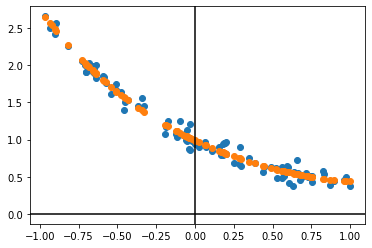

In [ ]:
# Construct data
f = lambda x: np.exp(-x)
xdata = np.random.uniform(low=-1.0, high=1.0, size=[100])
ydata = f(xdata) + np.random.normal(scale=0.08, size=[100])

# Fit a fifth-degree polynomial with regression
X = np.column_stack([xdata, xdata**2.0, xdata**3.0, xdata**4.0, xdata**5.0])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)

# Print model
print("Model:", end="")
for c, b in zip([reg.intercept_]+list(reg.coef_), range(6)):
  print(f" + {c:.2f}x^{b}", end="")
print()

# Plot data and model predictions
plt.axhline(color="black"); plt.axvline(color="black")
plt.scatter(xdata, ydata)
plt.scatter(xdata, reg.predict(X))
plt.show()

## Fitting Sinusoids

Another obvious choice of library functions is sinusoids.

For example, suppose we know that the data is approximately sinusoidal with angular frequency $\omega$, then we could find a model of the form
$$ r\sin(\omega x + \psi) + b $$
by using the library $\{\sin(\omega x), \cos(\omega x)\}$:

$$ r \sin(\omega x + \psi) + b = w_0\sin(\omega x) + w_1\cos(\omega x) + b $$

We would just need to convert the cartesian coordinates $w_0, w_1$ into polar coordinates $r,\psi$:

$$ r = \sqrt{w_0^2 + w_1^2} \qquad \psi = \begin{cases} \cos^{-1}(w_0/r) & w_1 \ge 0 \\ 2\pi - \cos^{-1}(w_0/r) & w_1 < 0 \end{cases} $$

Model: 0.37sin(x) + 0.35cos(x) + 0.21
Model: 0.51sin(x + 0.76) + 0.21
Model R^2 value: 0.98


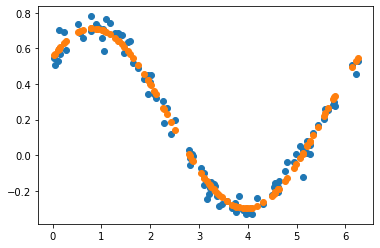

In [ ]:
# Construct data
f = lambda x: 0.5*tf.sin(x + 0.79) + 0.2
xdata = tf.random.uniform([100], minval=0.0, maxval=math.pi * 2.0)
ydata = f(xdata) + tf.random.normal([100], stddev=0.05)

# (x,y) -> (r,theta)
def cart2polar(x, y):
  r = math.sqrt(x**2.0 + y**2.0)
  theta = math.acos(x/r) if y >= 0.0 else 2*math.pi - math.acos(x/r)
  return [r,theta]

# Fit regression against our basis {sin(x), cos(x)}
# to get w0, w1, b
X = np.column_stack([tf.sin(xdata), tf.cos(xdata)])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)
w0, w1 = reg.coef_
b = reg.intercept_

# Output model equation in two different forms
# Plot data and model predictions
print(f"Model: {w0:.2f}sin(x) + {w1:.2f}cos(x) + {b:.2f}")
r, theta = cart2polar(w0, w1)
print(f"Model: {r:.2f}sin(x + {theta:.2f}) + {b:.2f}")
print(f"Model R^2 value: {reg.score(X, ydata):.2f}")
print(plt.scatter(xdata, ydata))
print(plt.scatter(xdata, reg.predict(X)))

Alternatively, suppose we know our data is sinusoidal, but don't know the angular frequency $\omega$:
$$ f(x) = \sin(\omega x) $$
To find $\omega$, we could fit a model of the form:
$$ w_1\sin(x) + w_2\sin(2x) + \cdots + w_n\sin(nx) $$
For now, this technique will remain informal, but in the future, it should be grounded on Fourier approximations. The general idea is that coefficients corresponding to sine functions with angular frequency near $\omega$ should be the largest coefficients. Based on the spread of the coefficients, we can interpolate to more precisely estimate the true value of $\omega$.



Closest frequency: 2.0


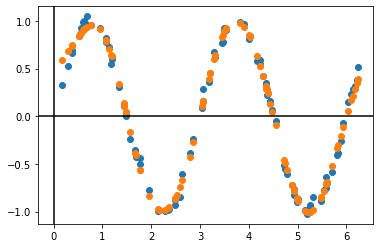

In [ ]:
# Construct data
f = lambda x: np.sin(2.1*x)
xdata = tf.random.uniform([100], minval=0.0, maxval=math.pi * 2.0)
ydata = f(xdata) + tf.random.normal([100], stddev=0.05)

# Fit a regression using a basis of sinusoids
X = np.column_stack([np.sin(n*0.5*xdata) for n in range(1,11)])
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, ydata)

# Find largest coefficient
i_of_largest_coef = np.argmax(reg.coef_)
print("Closest frequency:", 0.5*(i_of_largest_coef+1))

# Plot data and model predictions
plt.axhline(color="black"); plt.axvline(color="black")
plt.scatter(xdata, ydata)
plt.scatter(xdata, reg.predict(X))
plt.show()

---

# Approximating an Arbitrary Function using Convolution

This section describes a neural network configuration that can approximate a real-valued function $\mathbb{R} \rightarrow \mathbb{R}$ on a certain domain. The structure is inspired by signal convolution in linear systems, but it is also reminiscent of a fuzzy logic system. [Implementation](#scrollTo=x5qhSvWBw4bI) provides code for exploration and testing.


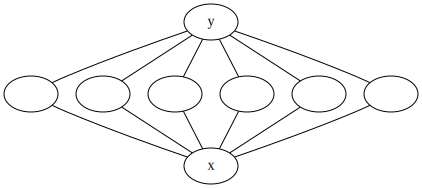

In [4]:
g = gv.Graph()
g.node_attr["label"] = ""
g.node("i", "x")
g.node("o", "y")
g.edges(["oa", "ob", "oc", "od", "oe", "of"])
g.edges(["ai", "bi", "ci", "di", "ei", "fi"])
g

The network has one input node, one output node, and one hidden layer. Let $h$ denote the number of nodes in the hidden layer. The approximation becomes better as $h$ increases.

Broadly, this network approximates a function by partitioning the domain of interest into $h$ equally-sized segments. The goal for any input is to get one particular node in the hidden layer to activate while the rest are deactivated. The activated node should correspond to the segment in which the input resides. The final set of weights can then easily be tuned so that the final output corresponds to the activated node according to the function being approximated.

Intuitively, each hidden node "detects" when the input is close to a particular value. To accomplish this, an activation function $a$ should be used such that:

$$a(0) = 1$$
$$\lim_{x \rightarrow \infty} a(x) = \lim_{x \rightarrow -\infty} a(x) = 0$$

For example, a gaussian or "spike" curve will suffice. Now suppose the $i$-th hidden node needs to detect when the input is near $x_i$. Then the activation $v_i$ of that node should be:

$$ v_i = a(wx -wx_i) $$

The weight $w$ can be varied, but the bias needs to be set so that $v_i = 1$ when $x = x_i$.

If we are approximating a function $f$, then the output $y$ is given by:
$$ y = \sum_{i=1}^{h} v_i f(x_i) $$

The neural network is essentially just calculating $f$ by approximating the following equation:

$$ f(x) = \int_{a}^{b} f(\tau)\ \delta(x - \tau)\ d\tau \approx \sum_{i=1}^{h} f(i \Delta)\ r(x - i \Delta) $$

where $(a,b)$ is our domain of interest, $\Delta = (b - a)/h$, $r(0) = 1$, and $r(x) = 0$ for $x \ge h$ or $x \le -h$.

If we substitute the computation for $v_i$ into the equation for $y$, we can see the similarity:

$$ y = \sum_{i=1}^{h} f(x_i)\ a(wx - wx_i)$$

If we let $x_i = i\Delta$ and $a(wt) = r(t)$, then the correspondence becomes complete.

$$ y = \sum_{i=1}^{h} f(i\Delta)\ a(w \cdot (x - i\Delta))$$

## Implementation

Currently, the function being approximated is $0.5 \sin(\pi x)$. Change [this cell](#scrollTo=AKMcQ9OXEPdR) if you want to approximate a different function.

[This cell](#scrollTo=zXPo8b9yndcO) manually sets the weights and biases of the network to the values prescribed by the theory. These are not guarenteed to be the best values (training the network afterwards does give improvements), but gives a good starting point.

If the weights and biases are randomly initialized, the network probably won't learn on its own to use this approximation method. It just serves as a demonstration of how a network with one hidden layer could theoretically learn any real valued function.

In [ ]:
# Constructs a new model called "sinModel"
# MyModel(h) constructs the 3-layer network described above with h
# nodes in the hidden layer.
class MyModel(tf.keras.Model):
  def __init__(self, h, **kwargs):
    super().__init__(**kwargs)
    #self.a = lambda x: tf.exp(-x**2)   # the gaussian activation function
    self.a = lambda x: tf.maximum(1-tf.abs(x), 0)  # sawtooth activation
    self.w1 = tf.Variable(tf.random.uniform(shape=[1, h]))
    self.b1 = tf.Variable(tf.random.uniform(shape=[1, h]))
    self.w2 = tf.Variable(tf.random.uniform(shape=[h, 1]))
    self.b2 = tf.Variable(tf.random.uniform(shape=[1, 1]))
  def hl_act(self, i, x, **kwargs):
    w1 = tf.reshape(self.w1[0,i], [1, 1])
    b1 = tf.reshape(self.b1[0,i], [1, 1])
    return self.a(tf.matmul(x, w1) + b1)
  def __call__(self, x, **kwargs):
    hiddenlayer = self.a(tf.matmul(x, self.w1) + self.b1)
    return tf.matmul(hiddenlayer, self.w2) + self.b2

sinModel = MyModel(6)

In [ ]:
# The function we want to approximate.
# In this case, 0.5sin(pi*x)
def f(x):
  return 0.5 * tf.sin(math.pi * x)

In [ ]:
# Manually set the weights and biases to approximate f on
# the interval [0,1]. Six sample values are used.

parts = tf.constant([[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]])
w = 5.0

sinModel = MyModel(6)
sinModel.w1.assign(tf.constant([[w, w, w, w, w, w]]))
sinModel.b1.assign(parts * -w)
sinModel.w2.assign(f(tf.reshape(parts, (6, 1))))
sinModel.b2.assign(tf.zeros(shape=(1,1)))

<tf.Variable 'UnreadVariable' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>

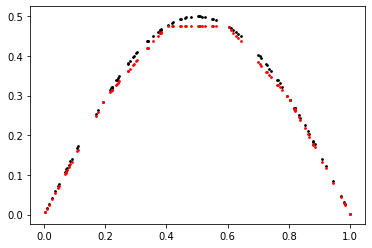

In [ ]:
# Test: plot the model approximation and the actual function f
x = tf.random.uniform((100, 1, 1), minval=0.0, maxval=1.0)
y = f(x)
y_obs = sinModel(x)
plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

In [ ]:
# Train the model
sinModel.compile(run_eagerly=False,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                loss=tf.keras.losses.mean_squared_error)
sinModel.fit(x, y, epochs=1000, batch_size=100, verbose=0)

In [ ]:
# print weights and biases
print(sinModel.w1)

<tf.Variable 'Variable:0' shape=(1, 6) dtype=float32, numpy=
array([[5.       , 4.999203 , 4.9981747, 5.000848 , 5.0031466, 5.       ]],
      dtype=float32)>


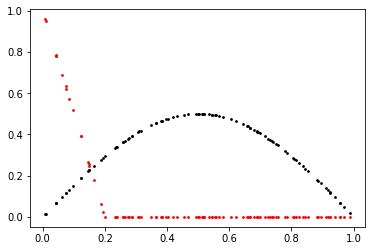

In [ ]:
# plot the activation of the 0-th hidden node
x = tf.random.uniform((100, 1, 1), minval=0.0, maxval=1.0)
y = f(x)
y_obs = sinModel.hl_act(0, x)

plt.scatter(x, y, c="black", s=3)
plt.scatter(x, y_obs, c="red", s=3)
plt.show()

## 4-layer version

Commonly used activation functions like sigmoid and the rectified linear don't usually tend toward zero on both ends. However, inserting another hidden layer allows us to use sigmoidal activation functions.

Broadly, the purpose of the nodes in the second hidden layer is the same as the hidden nodes in the 3-layer version: to activate when the input is close to some fixed value. The nodes in the first hidden layer should be zero, when read from left to right, until some node where the values switch to one.

Speaking of the hidden layers in terms of signals, the second hidden layer is the "derivative" of the first, and the feed-forward calculation between them can be compared to convolving the first signal with the $\delta$ signal.

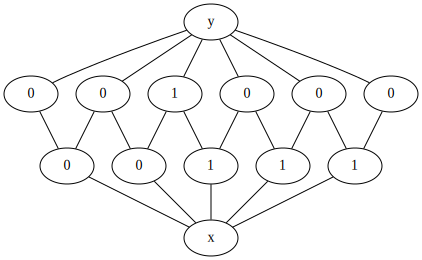

In [ ]:
g = gv.Graph()
g.node("i", "x")
g.node("o", "y")
for n in ["u", "v", "a", "b", "d", "e", "f"]: g.node(n, "0")
for n in ["w", "x", "y", "c"]: g.node(n, "1")
g.edges(["oa", "ob", "oc", "od", "oe", "of"])
g.edges(["au", "bu", "bv", "cv", "cw", "dw", "dx", "ex", "ey", "fy"])
g.edges(["ui", "vi", "wi", "xi", "yi"])
g